In [1]:
from src.preprocessing import *
from src.metrics import *
from src.visualisation import *
from src.NetworkGraphs import *
from math import sqrt
import networkx as nx
from IPython.display import display

In [2]:
Custom_networkGraphs = NetworkGraphs('../datasets/inf-USAir97.mtx', type="CUSTOM")

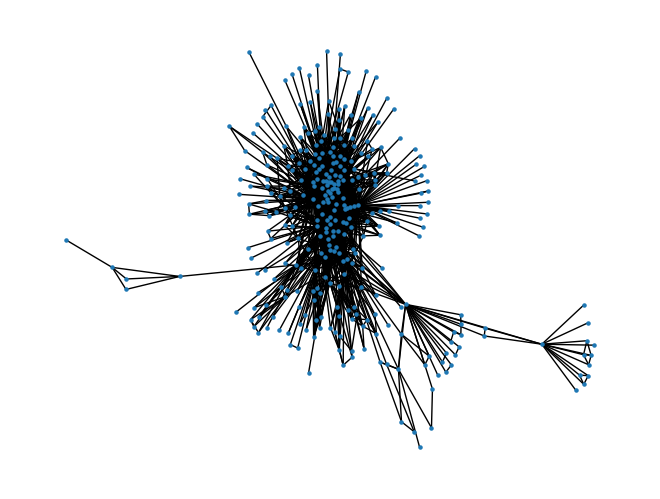

In [4]:
nx.draw(Custom_networkGraphs.MultiGraph,Custom_networkGraphs.pos,node_size=5)

In [2]:
Crypto_networkGraphs = NetworkGraphs('../datasets/Dune_Eth_transaction.csv', type="CRYPTO")

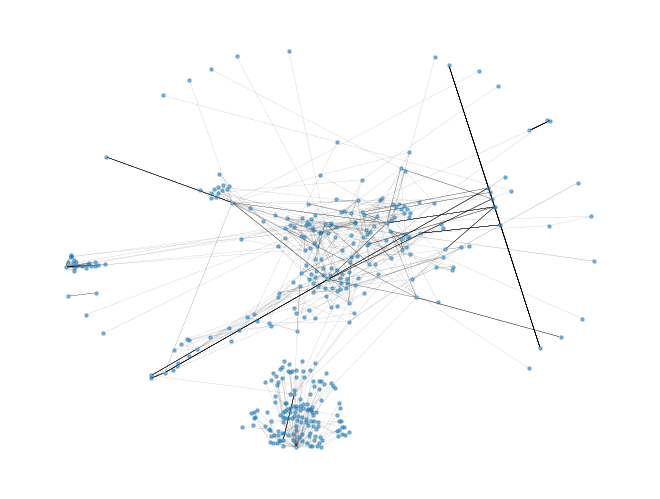

In [34]:
pos = nx.spring_layout(Crypto_networkGraphs.MultiDiGraph,k=4/sqrt(Crypto_networkGraphs.MultiDiGraph.number_of_nodes()), iterations=150, weight=None)
nx.draw(Crypto_networkGraphs.MultiDiGraph,pos, with_labels=False, node_size=5, width=0.1, arrowsize=0.1,alpha=0.5)

In [11]:
networkGraphs = NetworkGraphs('../datasets/Railway.csv', type="RAILWAY", spatial =True)

Excluded 0 stations


/Users/admin/Jupyter_notebooks/GroupProject/src/NetworkGraphs.py:70: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filename)


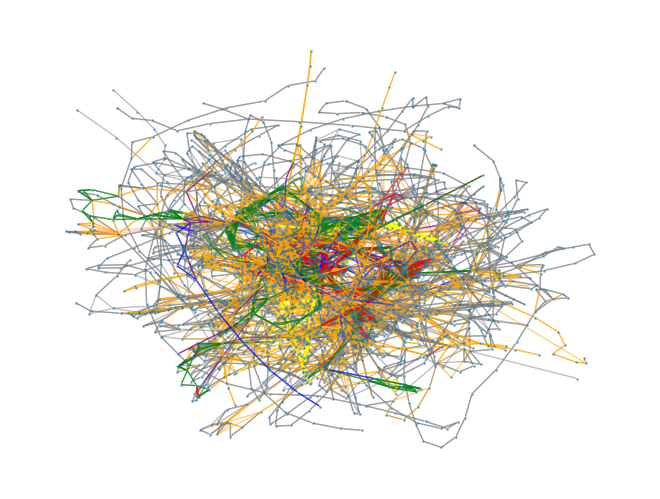

In [28]:
pos = nx.spring_layout(networkGraphs.DiGraph, k=2/sqrt(networkGraphs.Graph.number_of_nodes()), iterations=50)
nx.draw(networkGraphs.DiGraph,pos, with_labels=False, node_size=1, width=1, arrowsize=0.1,alpha=0.5,edge_color=networkGraphs.colors['DiGraph'])

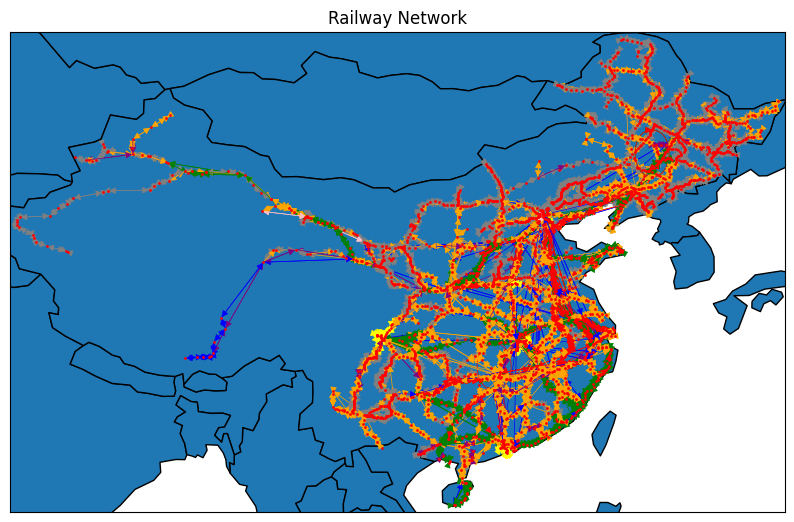

In [9]:
plt = static_visualisation(networkGraphs, 'Railway Network', directed=True, multi=False)

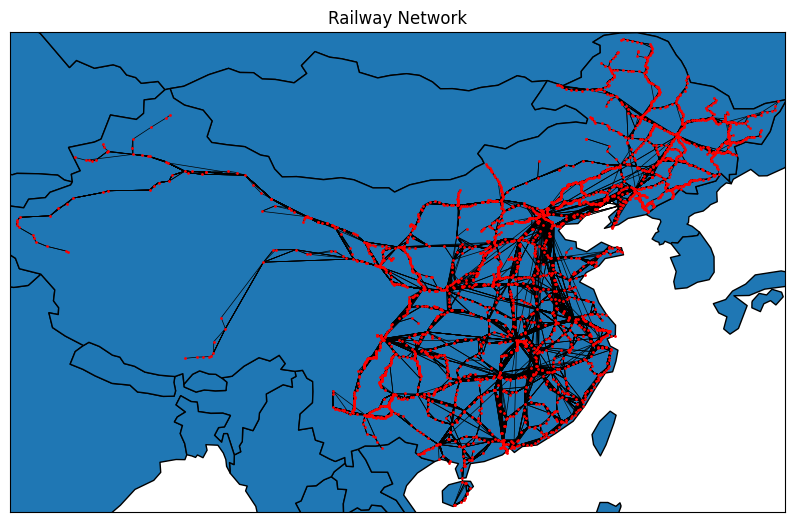

In [11]:
plt = static_visualisation(networkGraphs, 'Railway Network', directed=False, multi=True)

# Graph Statistics

In [ ]:
global_metrics = compute_global_metrics(networkGraphs)
global_metrics

In [ ]:
directed_node_metrics = compute_node_metrics(networkGraphs, directed=True)
directed_node_metrics

In [ ]:
html = export_to_csv(directed_node_metrics, 'directed_node_metrics.csv')

In [ ]:
undirected_node_metrics = compute_node_metrics(networkGraphs, directed=False)
undirected_node_metrics

# VISUALISATION

In [ ]:
plt_directed = plot_static_on_map(networkGraphs, 'Railway Network Directed Graph', directed=True)
plt_directed.show()

In [ ]:
plt_undirected = plot_static_on_map(networkGraphs, 'Railway Network Undirected Graph', directed=False)
plt_undirected.show()

# Spatial and Temporal Analysis

### Create frames of the graph
May take very long to create all of the frame images for 2 Days, one frame is created every 5 minute. You may change the range to create less frames and a shorter video.

In [ ]:
%matplotlib Notebook
temporal_graphs = create_temporal_subgraph(networkGraphs)
slider, plt = plot_temporal_graphs(temporal_graphs)
display(slider)
plt.show()

In [ ]:
temporal_graphs = create_temporal_subgraph(networkGraphs,0, (3*24+12)*60, 10)

In [ ]:
%matplotlib notebook
slider, plt = plot_temporal_graphs(temporal_graphs)

### Create a video of the graph with cv2 (OpenCV)

In [ ]:
# import cv2
# import os
#
# # Path to the folder containing the image frames
# frames_folder = 'frames/'
#
# # Get the list of frame filenames in the folder
# frame_filenames = os.listdir(frames_folder)
#
# # Sort the filenames in ascending order
# frame_filenames.sort(key=lambda x: int(x[:-4]))
#
# # Read the first frame to get its dimensions
# frame = cv2.imread(frames_folder + frame_filenames[0])
# height, width, layers = frame.shape
#
# # Create a VideoWriter object to write the video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video = cv2.VideoWriter('output.mp4', fourcc, 30, (width, height))
#
# # Loop through the frames and add them to the video
# i=0
# for filename in frame_filenames:
#     frame = cv2.imread(frames_folder + filename)
#     video.write(frame)
#     print(f"\r{i/2764*100:.2f}%", end="")
#     i+=1
#
# # Release the VideoWriter object and display a message
# video.release()
# print('\nVideo saved as output.mp4')

# SHORTEST PATH ANALYSIS

In [ ]:
get_shortest_path(networkGraphs, source=1136, target=1095, directed=False)